# Comparing different mutation strategies in Differential Evolution
In this exercise, we are going to evaluate the performance of different mutation strategies in **Differential Evolution** (DE)on a set of benchmark functions. We will implement DE from scratch. The benchmark functions that we will use are the following:

- **Griewank**:

    $f(x) = 1 + \frac{1}{4000} \sum_{i=1}^{n} x_i^2 - \prod_{i=1}^{n} \cos\left(\frac{x_i}{\sqrt{i}}\right)$

- **Rastrigin**:

    $f(x) = 10 \cdot n + \sum_{i=1}^{n} \left( x_i^2 - 10 \cdot \cos(2\pi x_i) \right)$

- **Schaffer**

    $f(x) = \sum_{i=1}^{n-1} \left( x_i^2 + x_{i+1}^2 \right)^{0.25} \cdot \left[ \sin^2\left(50 \cdot (x_i^2 + x_{i+1}^2)^{0.1}\right) + 1 \right]$

- **Rosenbrock**

    $f(x) = \sum_{i=1}^{n-1} \left[100 \cdot (x_{i+1} - x_i^2)^2 + (1 - x_i)^2\right]$

Let's import some useful modules.

In [309]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

Implement the benchmark functions.

In [310]:
def griewank(x):
    sum_sq = sum(xi**2 for xi in x)
    prod_cos = math.prod(math.cos(xi / math.sqrt(i + 1)) for i, xi in enumerate(x))
    return 1 + (1/4000) * sum_sq - prod_cos

In [311]:
def rastrigin(x):
    n = len(x)
    sum_sq = sum(xi**2 - (10 * math.cos(2 * math.pi * xi)) for xi in x)
    return 10 * n + sum_sq

In [312]:
def schaffer(x):
    n = len(x)
    result = 0
    for i in range(n-1):
        term = (x[i]**2 + x[i+1]**2)
        result += (term**0.25) * (math.sin(50 * (term**0.1))**2 + 1)
    return result

In [313]:
def rosenbrock(x):
    n = len(x)
    result = 0
    for i in range(n - 1):
        result += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return result


We can now define a function to plot a given benchmark function and a collection of points on it.

In [314]:
def plot_function(pop, func, val_range, title):
    ax = plt.figure(figsize=(20,10)).add_subplot(projection='3d')
    ax.set_title(title)
    xvals = np.linspace(val_range[0], val_range[1], 10*(val_range[1]-val_range[0]))
    yvals = np.linspace(val_range[0], val_range[1], 10*(val_range[1]-val_range[0]))
    xx, yy = np.meshgrid(xvals, yvals)
    z = np.zeros_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            input_vector = [xx[i, j], yy[i, j]]
            z[i, j] = func(input_vector)
    ax.plot_surface(xx, yy, z, antialiased=True, alpha=0.2)
    x_pop = [p[0] for p in pop]
    y_pop = [p[1] for p in pop]
    z_pop = [func(p) for p in pop]
    ax.scatter(x_pop, y_pop, z_pop, c="red")
    return ax

Implement now different versions of Differential Mutation (e.g., *DE/rand/1*, *DE/best/1*, etc...)

In [315]:
def donor_de_rand_1(pop, current, best, F=2):
    a, b, c = random.choices(pop, k=3)
    return a + F * (b - c)

In [316]:
def donor_de_best_1(pop, current, best, F=2):
    b, c = random.choices(pop, k=2)
    return best + F * (b - c)

In [317]:
def donor_de_curr2best_1(pop, current, best, F=2):
    b, c = random.choices(pop, k=2)
    return current + F * (best-current) + F * (b - c)

In [318]:
def donor_de_rand_2(pop, current, best, F=2):
    a, b, c, d, e = random.choices(pop, k=5)
    return a + F * (b - c) + F * (d - e)

In [319]:
def donor_de_rand2best_1(pop, current, best, F=2):
    a, b, c = random.choices(pop, k=3)
    return a + F * (best-a) + F * (b - c)

Implement now a function to get the trial vector and one for the selection.

In [320]:
def trial_vector(x, v, p_cr = 0.5):
    m = len(x)
    I_rnd = np.random.randint(0, m-1)
    u = np.zeros(m)
    for i in range(0, m):
        if np.random.random() < p_cr:
            u[i] = v[i]
        else:
            u[i] = x[i]
    u[I_rnd] = v[I_rnd]
    return u

In [321]:
def selection(x, u, fit):
    if fit(x) < fit(u):
        return x
    else:
        return u

Exploit the previous functions to implement a ```generation``` function. 

In [322]:
def generation(pop, fit, dm, best):
    next_gen = []
    for i in range(0, len(pop)):
        v = dm(pop, pop[i], best)
        u = trial_vector(pop[i], v)
        next_gen.append(selection(pop[i], u, fit))
    return next_gen

We can now define differential evolution.
The function returns the last population, the history of all generations and the best individual.

In [323]:
def differential_evolution(n_gens, pop_size, search_space, fit, dm):
    pop = []
    hist = []
    n = len(search_space)
    for _ in range(0, pop_size):
        pop.append(np.array([np.random.uniform(search_space[i][0], search_space[i][1])
                             for i in range(0, n)]))
    hist.append(pop)
    best = min(pop, key=fit)
    for _ in range(0, n_gens):
        pop = generation(pop, fit, dm, best)
        hist.append(pop)
        best = min(pop, key=fit)
    return pop, hist, best

Try all the methods defined abow on the different benchmark functions and see how they work.

In [324]:
np.random.seed(0)
random.seed(0)

n_gen = 100
pop_size = 20

f = rastrigin
search_space = [[-10, 10], [-10, 10]]
plot_interval = [-10, 10]

In [325]:
last_rand1, hist_rand1, best_rand1 = differential_evolution(n_gen, pop_size, search_space, f, donor_de_rand_1)
last_best1, hist_best1, best_best1 = differential_evolution(n_gen, pop_size, search_space, f, donor_de_best_1)
last_curr2best1, hist_curr2best1, best_curr2best1 = differential_evolution(n_gen, pop_size, search_space, f, donor_de_curr2best_1)
last_rand2, hist_rand2, best_rand2 = differential_evolution(n_gen, pop_size, search_space, f, donor_de_rand_2)
last_rand2best1, hist_rand2best1, best_rand2best1 = differential_evolution(n_gen, pop_size, search_space, f, donor_de_rand2best_1)

print(f"DE/rand/1: {f(best_rand1)}")
print(f"DE/best/1: {f(best_best1)}")
print(f"DE/current-to-best/1: {f(best_curr2best1)}")
print(f"DE/rand/2: {f(best_rand2)}")
print(f"DE/rand-to-best/1: {f(best_rand2best1)}")

DE/rand/1: 0.05340207743602221
DE/best/1: 1.0875951284343728
DE/current-to-best/1: 1.0449561633020323
DE/rand/2: 0.5181199774122973
DE/rand-to-best/1: 0.1858229422096933


<Axes3D: title={'center': 'DE/rand-to-best/1'}>

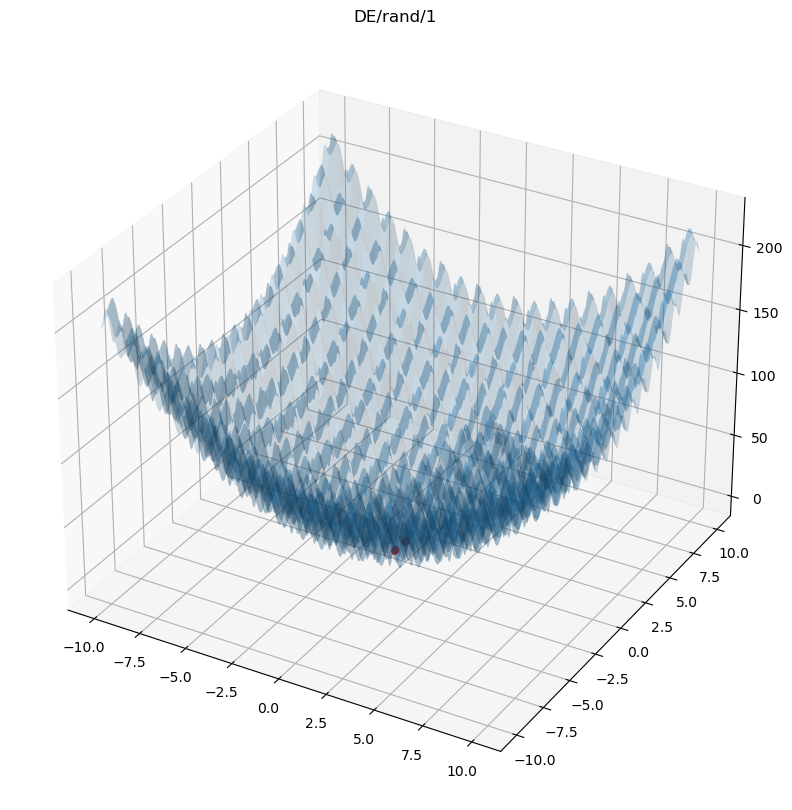

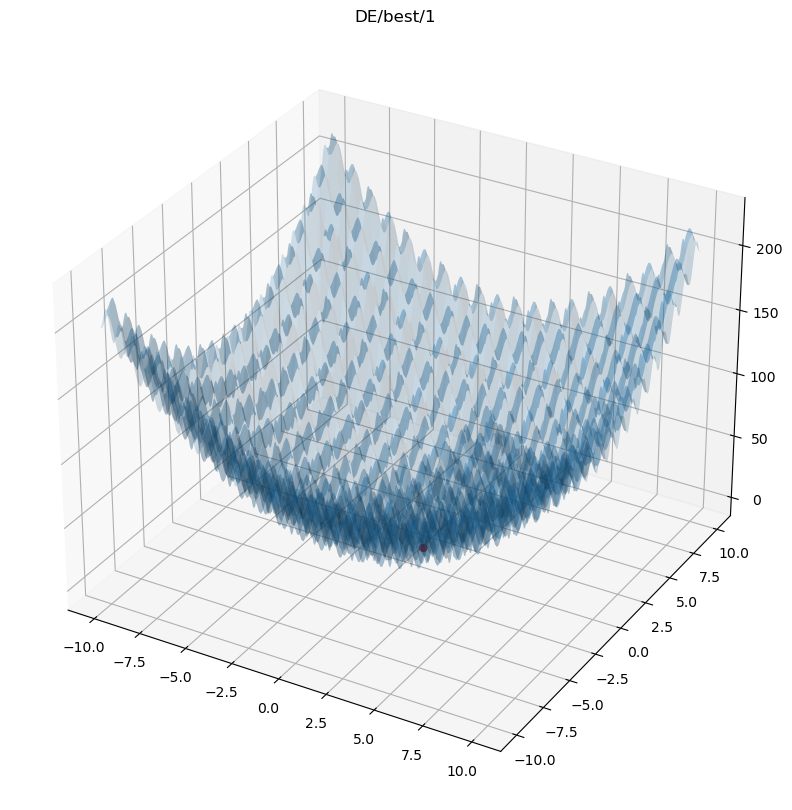

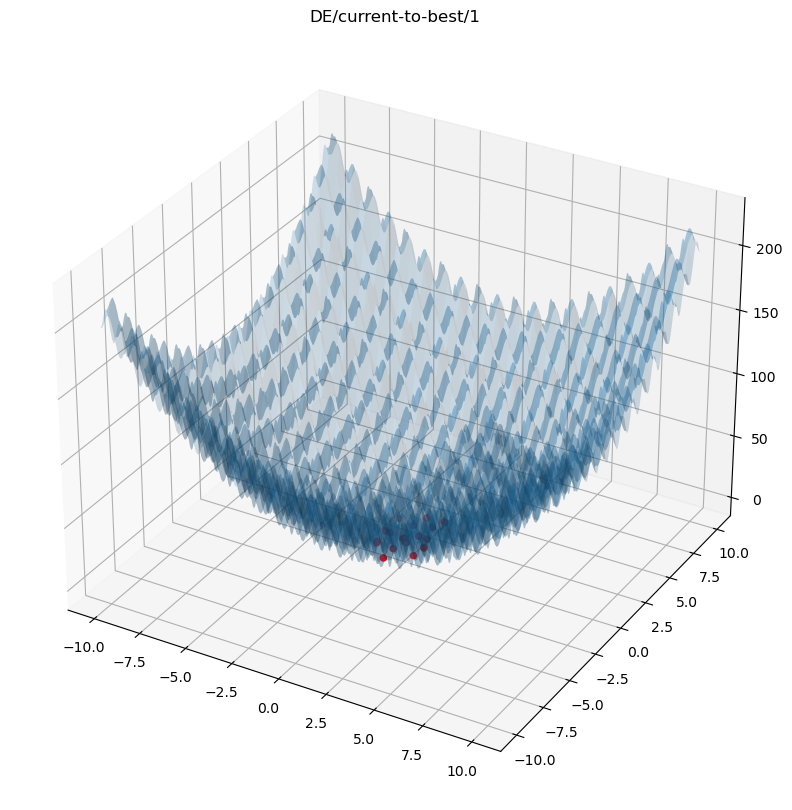

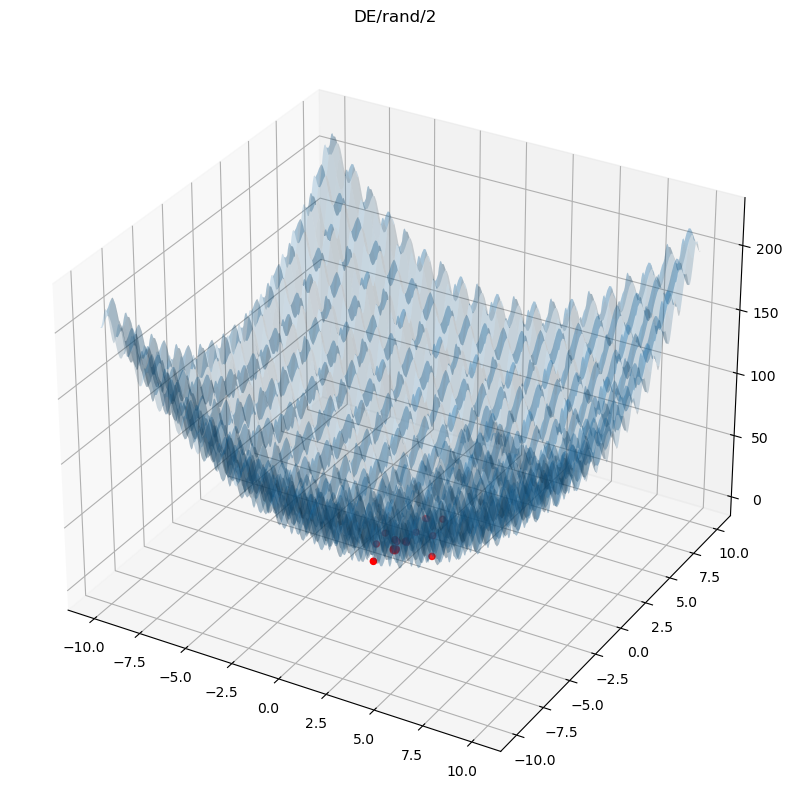

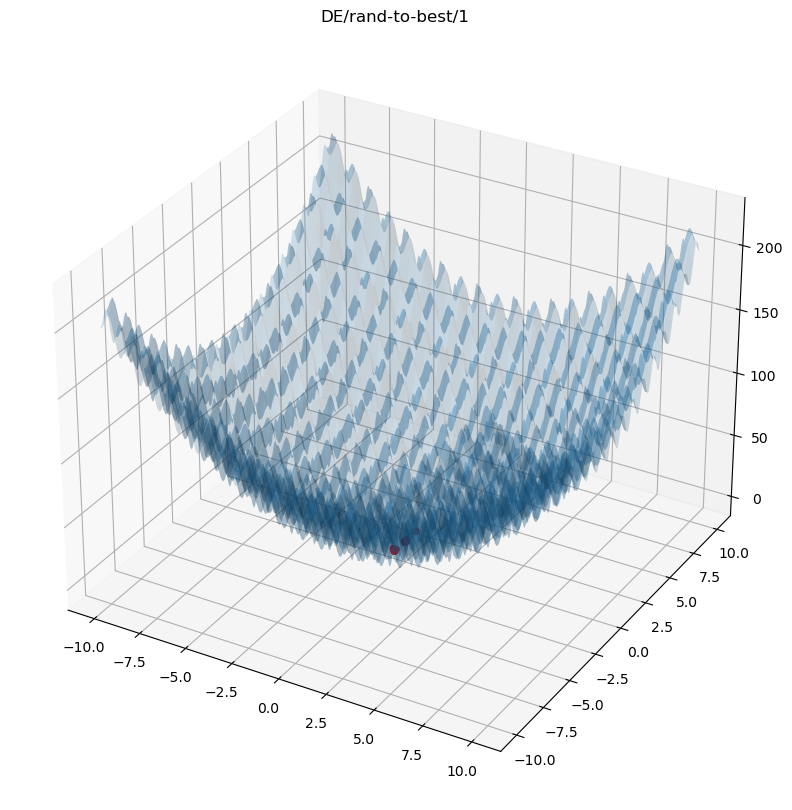

In [326]:
plot_function(last_rand1, f, plot_interval, "DE/rand/1")
plot_function(last_best1, f, plot_interval, "DE/best/1")
plot_function(last_curr2best1, f, plot_interval, "DE/current-to-best/1")
plot_function(last_rand2, f, plot_interval, "DE/rand/2")
plot_function(last_rand2best1, f, plot_interval, "DE/rand-to-best/1")

In [330]:
def plot_history(history, fit, tit):
    best_hist = []
    for pop in history:
        best_hist.append(fit(min(pop, key=fit)))
    plt.plot(best_hist)
    plt.title(tit)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    plt.show()

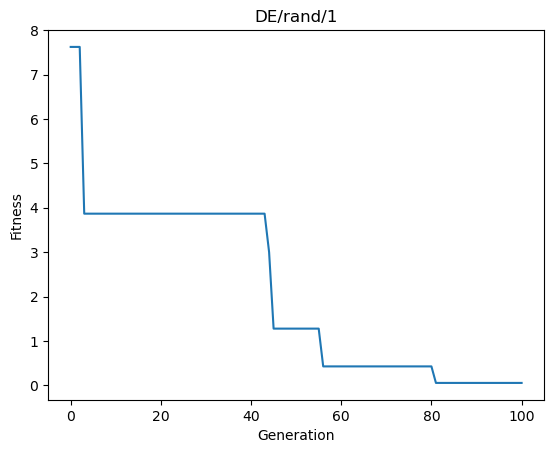

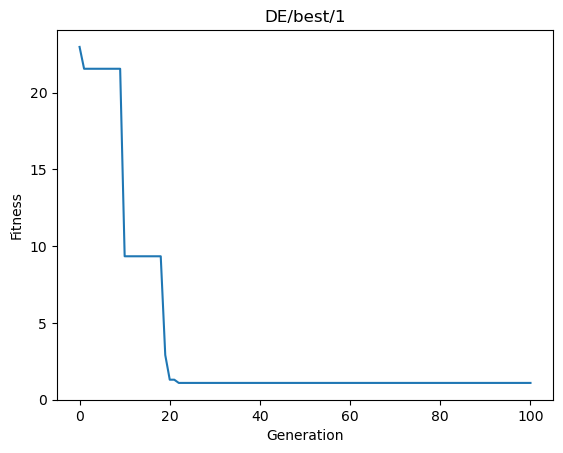

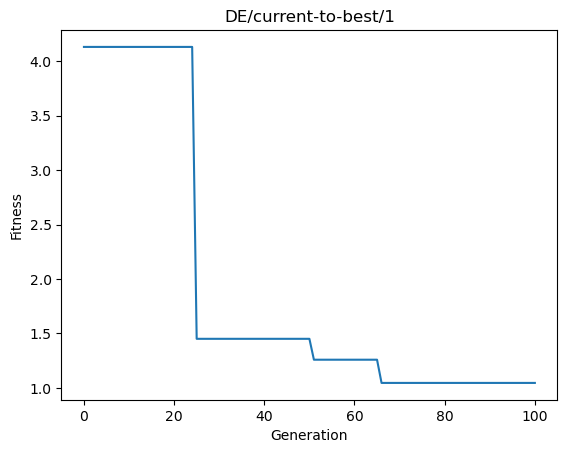

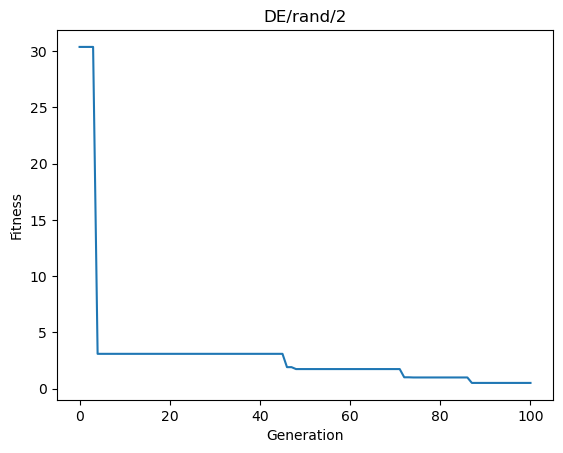

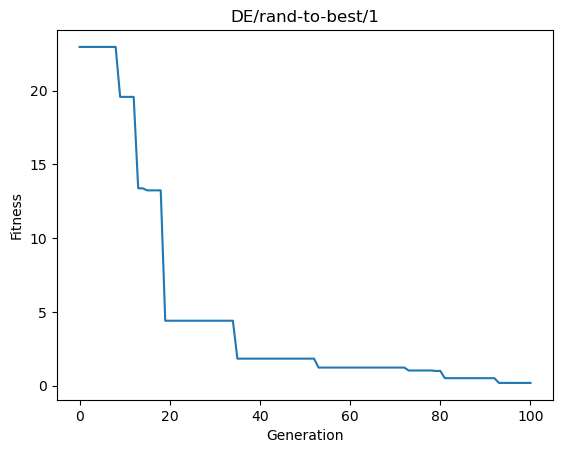

In [331]:
plot_history(hist_rand1, f, "DE/rand/1")
plot_history(hist_best1, f, "DE/best/1")
plot_history(hist_curr2best1, f, "DE/current-to-best/1")
plot_history(hist_rand2, f, "DE/rand/2")
plot_history(hist_rand2best1, f, "DE/rand-to-best/1")